# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


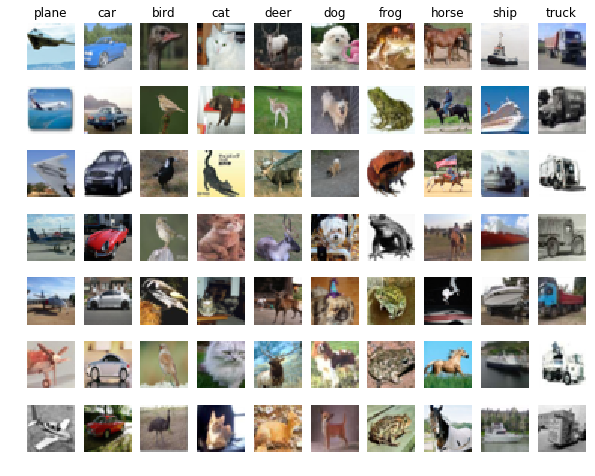

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [3]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [4]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


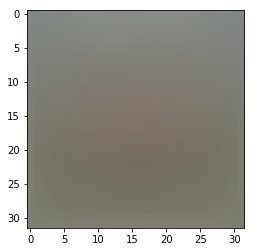

In [5]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [6]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [7]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.104437


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 28.418018 analytic: 28.418018, minus: 0.000000, relative error: 9.965357e-12
numerical: -15.335366 analytic: -15.335366, minus: 0.000000, relative error: 1.614575e-11
numerical: 9.371406 analytic: 9.371406, minus: 0.000000, relative error: 3.543651e-12
numerical: 18.429376 analytic: 18.429376, minus: 0.000000, relative error: 7.790981e-13
numerical: 2.071230 analytic: 2.071230, minus: 0.000000, relative error: 1.554761e-10
numerical: -5.406832 analytic: -5.406832, minus: 0.000000, relative error: 1.736081e-10
numerical: -36.606348 analytic: -36.606348, minus: 0.000000, relative error: 4.600452e-12
numerical: 1.367666 analytic: 1.367666, minus: 0.000000, relative error: 6.294936e-11
numerical: -9.553075 analytic: -9.553075, minus: 0.000000, relative error: 2.454219e-11
numerical: -0.057064 analytic: -0.057064, minus: 0.000000, relative error: 3.814457e-09
numerical: -17.447406 analytic: -17.447406, minus: 0.000000, relative error: 1.314394e-12
numerical: 12.412008 analytic: 1

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [10]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# The losses should match but your vectorized implementation should be much faster.
print 'difference: %f' % (loss_naive - loss_vectorized)

Naive loss: 9.104437e+00 computed in 0.162638s
Vectorized loss: 9.104437e+00 computed in 0.004521s
difference: 0.000000


In [11]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.167021s
Vectorized loss and gradient: computed in 0.002094s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [12]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 18.652533
iteration 100 / 1500: loss 9.572064
iteration 200 / 1500: loss 5.867730
iteration 300 / 1500: loss 5.022546
iteration 400 / 1500: loss 4.888951
iteration 500 / 1500: loss 4.761306
iteration 600 / 1500: loss 4.919674
iteration 700 / 1500: loss 5.274217
iteration 800 / 1500: loss 5.095587
iteration 900 / 1500: loss 5.038068
iteration 1000 / 1500: loss 4.376370
iteration 1100 / 1500: loss 4.588229
iteration 1200 / 1500: loss 4.665173
iteration 1300 / 1500: loss 4.876052
iteration 1400 / 1500: loss 4.648825
That took 3.691537s


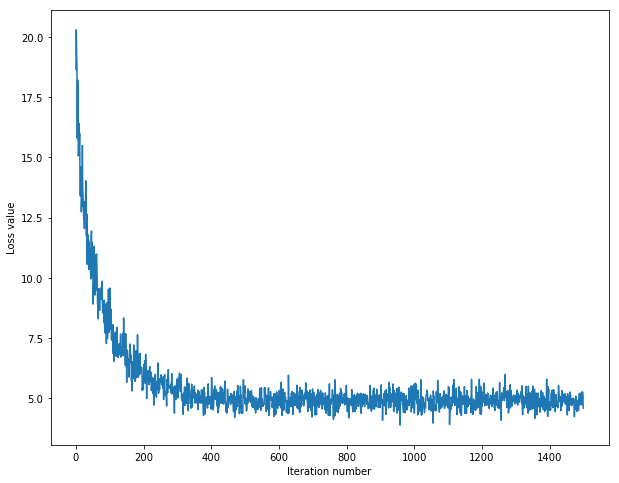

In [13]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.370714
validation accuracy: 0.388000


lr: 1e-10 reg: 0
iteration 0 / 15000: loss 17.232880
iteration 100 / 15000: loss 17.737374
iteration 200 / 15000: loss 17.228732
iteration 300 / 15000: loss 17.750073
iteration 400 / 15000: loss 20.618561
iteration 500 / 15000: loss 22.114326
iteration 600 / 15000: loss 18.795109
iteration 700 / 15000: loss 19.535669
iteration 800 / 15000: loss 19.142755
iteration 900 / 15000: loss 19.648464
iteration 1000 / 15000: loss 17.974279
iteration 1100 / 15000: loss 17.157863
iteration 1200 / 15000: loss 17.947795
iteration 1300 / 15000: loss 19.379893
iteration 1400 / 15000: loss 19.562548
iteration 1500 / 15000: loss 18.170841
iteration 1600 / 15000: loss 18.673018
iteration 1700 / 15000: loss 16.659639
iteration 1800 / 15000: loss 17.211103
iteration 1900 / 15000: loss 19.127073
iteration 2000 / 15000: loss 16.304762
iteration 2100 / 15000: loss 16.864179
iteration 2200 / 15000: loss 18.075256
iteration 2300 / 15000: loss 17.697928
iteration 2400 / 15000: loss 18.724487
iteration 2500 / 150

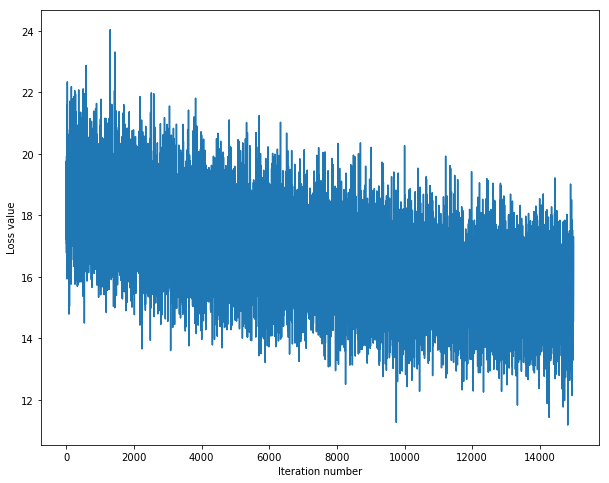

tr_acc: 0.158 val_acc: 0.17
lr: 1e-10 reg: 50000.0
iteration 0 / 15000: loss 24.616093
iteration 100 / 15000: loss 24.430795
iteration 200 / 15000: loss 24.290185
iteration 300 / 15000: loss 25.678624
iteration 400 / 15000: loss 23.278183
iteration 500 / 15000: loss 21.855529
iteration 600 / 15000: loss 24.143796
iteration 700 / 15000: loss 23.856519
iteration 800 / 15000: loss 24.670893
iteration 900 / 15000: loss 20.674287
iteration 1000 / 15000: loss 22.987241
iteration 1100 / 15000: loss 21.130913
iteration 1200 / 15000: loss 19.932228
iteration 1300 / 15000: loss 20.672397
iteration 1400 / 15000: loss 22.606475
iteration 1500 / 15000: loss 24.473099
iteration 1600 / 15000: loss 21.915283
iteration 1700 / 15000: loss 21.267893
iteration 1800 / 15000: loss 21.617415
iteration 1900 / 15000: loss 21.753808
iteration 2000 / 15000: loss 23.306859
iteration 2100 / 15000: loss 23.423441
iteration 2200 / 15000: loss 23.143468
iteration 2300 / 15000: loss 19.283905
iteration 2400 / 15000: l

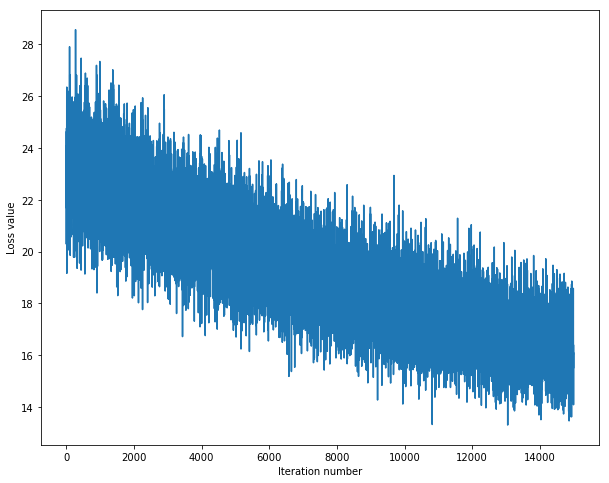

tr_acc: 0.112897959184 val_acc: 0.112
lr: 1e-10 reg: 100000.0
iteration 0 / 15000: loss 19.641263
iteration 100 / 15000: loss 20.605038
iteration 200 / 15000: loss 21.599399
iteration 300 / 15000: loss 22.014275
iteration 400 / 15000: loss 17.975903
iteration 500 / 15000: loss 21.122138
iteration 600 / 15000: loss 19.420428
iteration 700 / 15000: loss 20.343075
iteration 800 / 15000: loss 20.249748
iteration 900 / 15000: loss 20.426778
iteration 1000 / 15000: loss 19.785372
iteration 1100 / 15000: loss 18.629518
iteration 1200 / 15000: loss 22.357187
iteration 1300 / 15000: loss 20.205638
iteration 1400 / 15000: loss 16.449644
iteration 1500 / 15000: loss 20.277828
iteration 1600 / 15000: loss 19.800691
iteration 1700 / 15000: loss 19.058882
iteration 1800 / 15000: loss 16.914192
iteration 1900 / 15000: loss 18.543345
iteration 2000 / 15000: loss 21.088482
iteration 2100 / 15000: loss 21.441807
iteration 2200 / 15000: loss 19.776145
iteration 2300 / 15000: loss 20.117951
iteration 2400

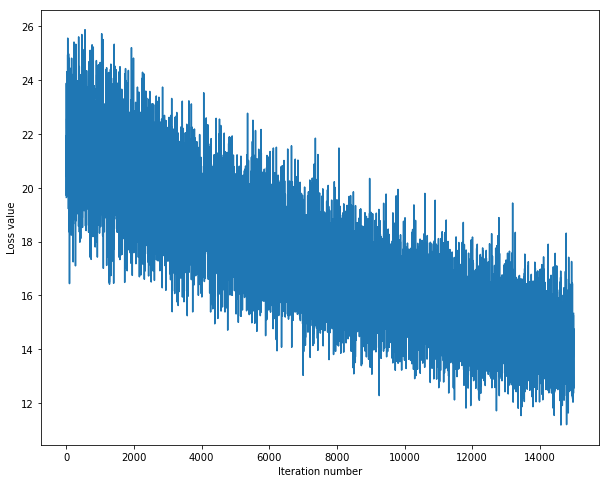

tr_acc: 0.143653061224 val_acc: 0.146
lr: 1e-10 reg: 10000000000.0
iteration 0 / 15000: loss 28.490374
iteration 100 / 15000: loss 8.999025
iteration 200 / 15000: loss 8.998794
iteration 300 / 15000: loss 8.999224
iteration 400 / 15000: loss 8.998914
iteration 500 / 15000: loss 8.999248
iteration 600 / 15000: loss 8.999366
iteration 700 / 15000: loss 8.999208
iteration 800 / 15000: loss 8.998952
iteration 900 / 15000: loss 8.999385
iteration 1000 / 15000: loss 8.999273
iteration 1100 / 15000: loss 8.998834
iteration 1200 / 15000: loss 8.999118
iteration 1300 / 15000: loss 8.999045
iteration 1400 / 15000: loss 8.998927
iteration 1500 / 15000: loss 8.999125
iteration 1600 / 15000: loss 8.999048
iteration 1700 / 15000: loss 8.999184
iteration 1800 / 15000: loss 8.999176
iteration 1900 / 15000: loss 8.999222
iteration 2000 / 15000: loss 8.998942
iteration 2100 / 15000: loss 8.999046
iteration 2200 / 15000: loss 8.998779
iteration 2300 / 15000: loss 8.999529
iteration 2400 / 15000: loss 8.9

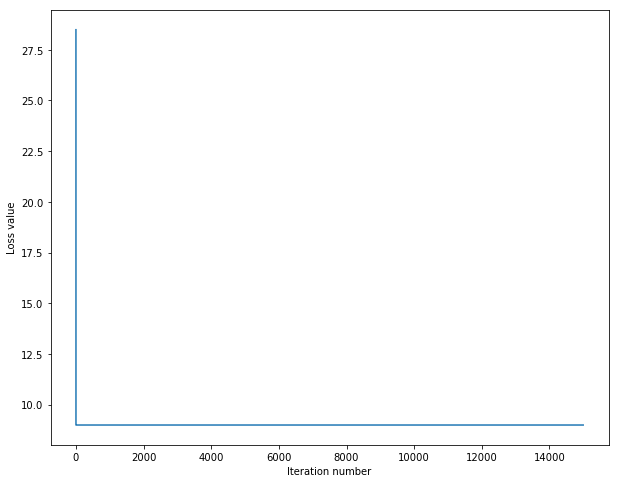

tr_acc: 0.226489795918 val_acc: 0.23
lr: 1e-08 reg: 0
iteration 0 / 15000: loss 22.391497
iteration 100 / 15000: loss 16.412877
iteration 200 / 15000: loss 14.564468
iteration 300 / 15000: loss 11.496152
iteration 400 / 15000: loss 13.109821
iteration 500 / 15000: loss 12.962756
iteration 600 / 15000: loss 10.548791
iteration 700 / 15000: loss 11.198160
iteration 800 / 15000: loss 11.243966
iteration 900 / 15000: loss 10.994272
iteration 1000 / 15000: loss 11.096571
iteration 1100 / 15000: loss 10.715156
iteration 1200 / 15000: loss 10.433083
iteration 1300 / 15000: loss 9.589826
iteration 1400 / 15000: loss 10.206962
iteration 1500 / 15000: loss 11.240573
iteration 1600 / 15000: loss 9.563466
iteration 1700 / 15000: loss 10.328599
iteration 1800 / 15000: loss 9.041875
iteration 1900 / 15000: loss 10.081609
iteration 2000 / 15000: loss 8.622810
iteration 2100 / 15000: loss 8.896760
iteration 2200 / 15000: loss 8.250185
iteration 2300 / 15000: loss 9.250020
iteration 2400 / 15000: loss 

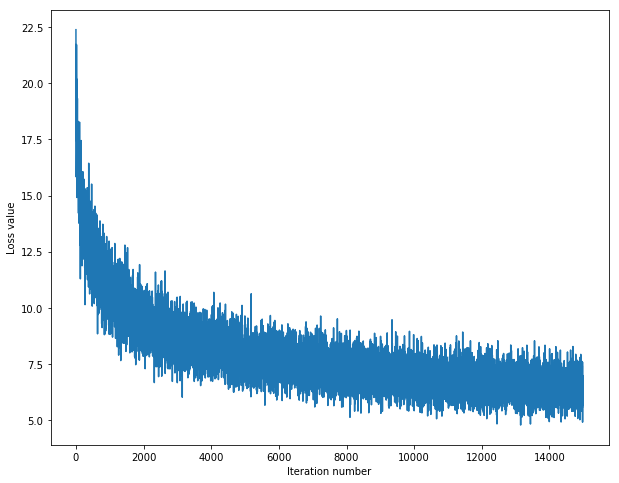

tr_acc: 0.306081632653 val_acc: 0.321
lr: 1e-08 reg: 50000.0
iteration 0 / 15000: loss 26.106345
iteration 100 / 15000: loss 17.961777
iteration 200 / 15000: loss 13.337071
iteration 300 / 15000: loss 12.395729
iteration 400 / 15000: loss 10.993847
iteration 500 / 15000: loss 9.673520
iteration 600 / 15000: loss 10.257027
iteration 700 / 15000: loss 9.325506
iteration 800 / 15000: loss 8.097431
iteration 900 / 15000: loss 8.537639
iteration 1000 / 15000: loss 8.431547
iteration 1100 / 15000: loss 7.379472
iteration 1200 / 15000: loss 7.537780
iteration 1300 / 15000: loss 7.078630
iteration 1400 / 15000: loss 5.792548
iteration 1500 / 15000: loss 6.835634
iteration 1600 / 15000: loss 5.905956
iteration 1700 / 15000: loss 6.396221
iteration 1800 / 15000: loss 6.601273
iteration 1900 / 15000: loss 6.634936
iteration 2000 / 15000: loss 6.090178
iteration 2100 / 15000: loss 5.824195
iteration 2200 / 15000: loss 5.634889
iteration 2300 / 15000: loss 5.362594
iteration 2400 / 15000: loss 4.96

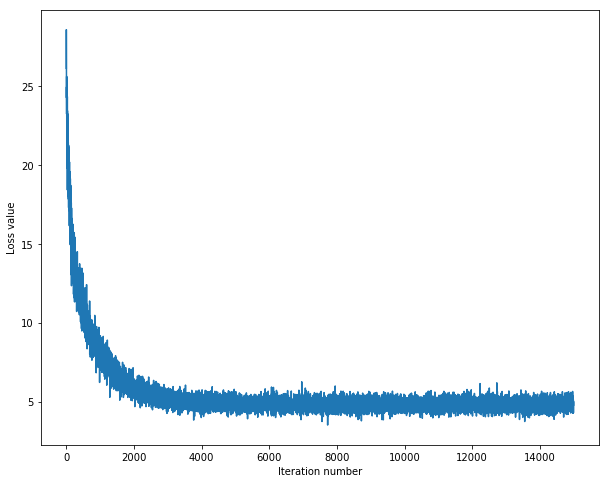

tr_acc: 0.375959183673 val_acc: 0.389
lr: 1e-08 reg: 100000.0
iteration 0 / 15000: loss 20.787538
iteration 100 / 15000: loss 15.008901
iteration 200 / 15000: loss 13.401015
iteration 300 / 15000: loss 12.080037
iteration 400 / 15000: loss 10.453863
iteration 500 / 15000: loss 8.376544
iteration 600 / 15000: loss 8.615210
iteration 700 / 15000: loss 7.184717
iteration 800 / 15000: loss 6.574919
iteration 900 / 15000: loss 6.801163
iteration 1000 / 15000: loss 6.617872
iteration 1100 / 15000: loss 5.728680
iteration 1200 / 15000: loss 5.718940
iteration 1300 / 15000: loss 5.211877
iteration 1400 / 15000: loss 5.864570
iteration 1500 / 15000: loss 5.746096
iteration 1600 / 15000: loss 5.618614
iteration 1700 / 15000: loss 5.696475
iteration 1800 / 15000: loss 5.314655
iteration 1900 / 15000: loss 5.509102
iteration 2000 / 15000: loss 5.521992
iteration 2100 / 15000: loss 4.855539
iteration 2200 / 15000: loss 5.145255
iteration 2300 / 15000: loss 5.317310
iteration 2400 / 15000: loss 5.08

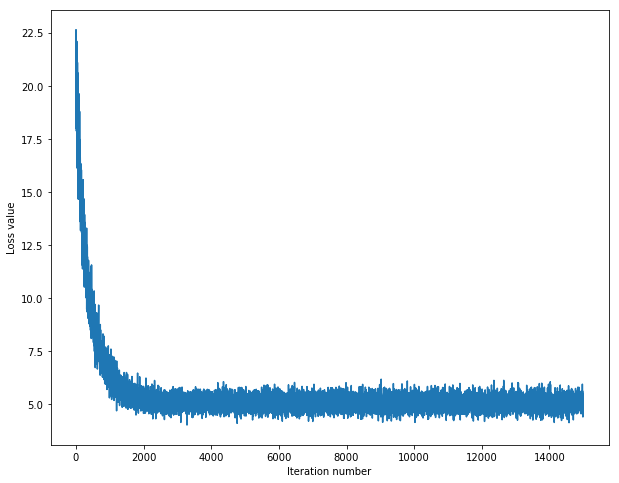

tr_acc: 0.362142857143 val_acc: 0.374
lr: 1e-08 reg: 10000000000.0
iteration 0 / 15000: loss 18.423864
iteration 100 / 15000: loss 543520548852124644342637063977102616547448383796890993911751755974464107959042503550012020425582115264292343394165949719714727070151060970978507316313084201467150841221603012078490956088352520011776000.000000
iteration 200 / 15000: loss nan
iteration 300 / 15000: loss nan
iteration 400 / 15000: loss nan
iteration 500 / 15000: loss nan
iteration 600 / 15000: loss nan
iteration 700 / 15000: loss nan
iteration 800 / 15000: loss nan
iteration 900 / 15000: loss nan
iteration 1000 / 15000: loss nan
iteration 1100 / 15000: loss nan
iteration 1200 / 15000: loss nan
iteration 1300 / 15000: loss nan
iteration 1400 / 15000: loss nan
iteration 1500 / 15000: loss nan
iteration 1600 / 15000: loss nan
iteration 1700 / 15000: loss nan
iteration 1800 / 15000: loss nan
iteration 1900 / 15000: loss nan
iteration 2000 / 15000: loss nan
iteration 2100 / 15000: loss nan
iteratio

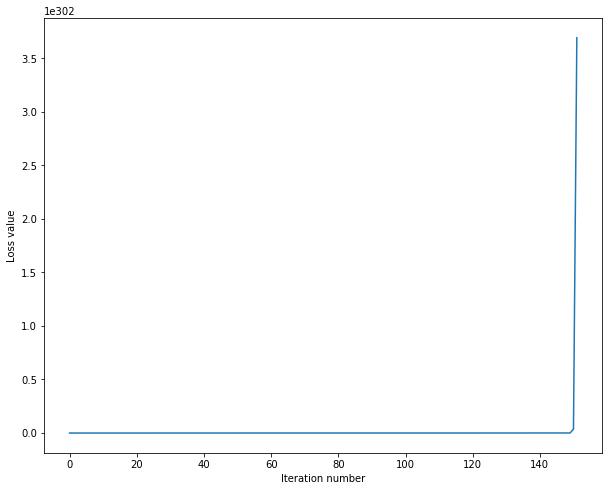

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-07 reg: 0
iteration 0 / 15000: loss 24.035061
iteration 100 / 15000: loss 13.944739
iteration 200 / 15000: loss 10.630841
iteration 300 / 15000: loss 8.796412
iteration 400 / 15000: loss 7.342195
iteration 500 / 15000: loss 7.872251
iteration 600 / 15000: loss 8.024639
iteration 700 / 15000: loss 7.478759
iteration 800 / 15000: loss 6.961632
iteration 900 / 15000: loss 7.359614
iteration 1000 / 15000: loss 5.712096
iteration 1100 / 15000: loss 6.170931
iteration 1200 / 15000: loss 7.115439
iteration 1300 / 15000: loss 6.406378
iteration 1400 / 15000: loss 6.980417
iteration 1500 / 15000: loss 6.728946
iteration 1600 / 15000: loss 6.882771
iteration 1700 / 15000: loss 5.973990
iteration 1800 / 15000: loss 5.659690
iteration 1900 / 15000: loss 6.311779
iteration 2000 / 15000: loss 7.107670
iteration 2100 / 15000: loss 6.723665
iteration 2200 / 15000: loss 6.869299
iteration 2300 / 15000: loss 5.572310
iteration 2400 / 15000: loss 5.722634
iter

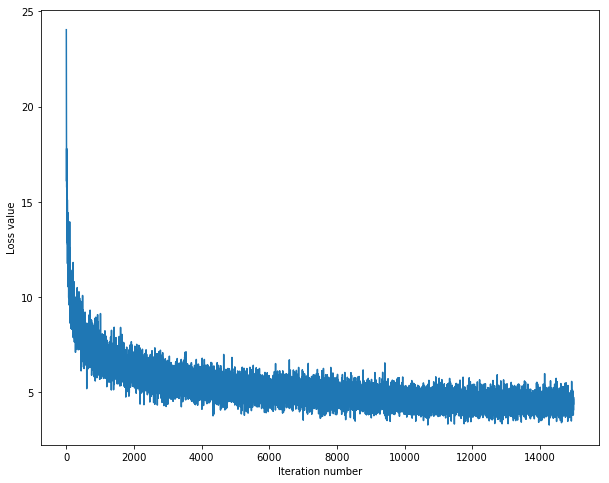

tr_acc: 0.384469387755 val_acc: 0.357
lr: 1e-07 reg: 50000.0
iteration 0 / 15000: loss 21.011573
iteration 100 / 15000: loss 7.936207
iteration 200 / 15000: loss 6.094360
iteration 300 / 15000: loss 5.086642
iteration 400 / 15000: loss 5.182925
iteration 500 / 15000: loss 4.560762
iteration 600 / 15000: loss 5.205061
iteration 700 / 15000: loss 4.681053
iteration 800 / 15000: loss 4.806390
iteration 900 / 15000: loss 5.384654
iteration 1000 / 15000: loss 5.270337
iteration 1100 / 15000: loss 5.449689
iteration 1200 / 15000: loss 4.424659
iteration 1300 / 15000: loss 4.570016
iteration 1400 / 15000: loss 4.711374
iteration 1500 / 15000: loss 4.699705
iteration 1600 / 15000: loss 4.690656
iteration 1700 / 15000: loss 4.842492
iteration 1800 / 15000: loss 4.656705
iteration 1900 / 15000: loss 4.896529
iteration 2000 / 15000: loss 5.011416
iteration 2100 / 15000: loss 4.950100
iteration 2200 / 15000: loss 4.401890
iteration 2300 / 15000: loss 5.456896
iteration 2400 / 15000: loss 4.762773


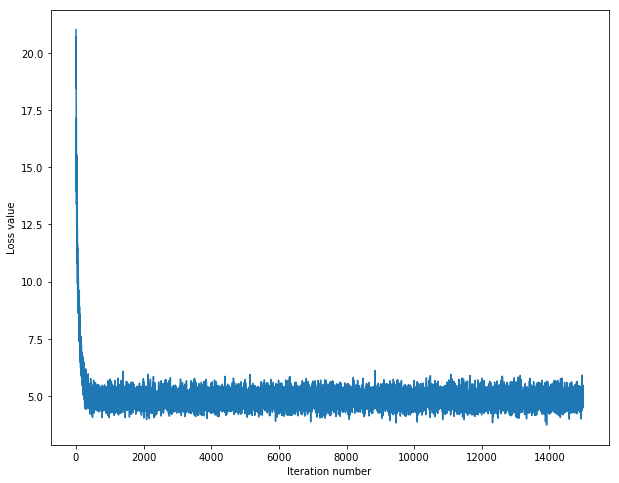

tr_acc: 0.368816326531 val_acc: 0.376
lr: 1e-07 reg: 100000.0
iteration 0 / 15000: loss 23.148958
iteration 100 / 15000: loss 6.003779
iteration 200 / 15000: loss 5.067443
iteration 300 / 15000: loss 4.983112
iteration 400 / 15000: loss 5.032678
iteration 500 / 15000: loss 4.598762
iteration 600 / 15000: loss 4.947394
iteration 700 / 15000: loss 4.823808
iteration 800 / 15000: loss 5.107971
iteration 900 / 15000: loss 5.325349
iteration 1000 / 15000: loss 4.586309
iteration 1100 / 15000: loss 5.423272
iteration 1200 / 15000: loss 4.828225
iteration 1300 / 15000: loss 4.925406
iteration 1400 / 15000: loss 5.621265
iteration 1500 / 15000: loss 5.119805
iteration 1600 / 15000: loss 4.767939
iteration 1700 / 15000: loss 5.429894
iteration 1800 / 15000: loss 5.100395
iteration 1900 / 15000: loss 5.426290
iteration 2000 / 15000: loss 4.921377
iteration 2100 / 15000: loss 5.026287
iteration 2200 / 15000: loss 5.093291
iteration 2300 / 15000: loss 5.662158
iteration 2400 / 15000: loss 5.435259

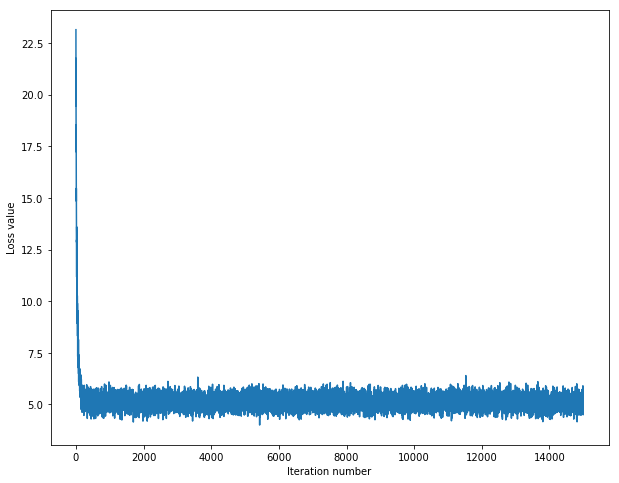

tr_acc: 0.354551020408 val_acc: 0.35
lr: 1e-07 reg: 10000000000.0
iteration 0 / 15000: loss 18.827366
iteration 100 / 15000: loss 12942866051391529420392976552620605126204481883348980783683220889183423337246528062739533849474493813550691935346416974239489675285950233419875078815074222261562863455637356307592582128358613257773209079265905775854653462215413367316092201263514411557175916241737027671853612742662961429233544370061312.000000
iteration 200 / 15000: loss nan
iteration 300 / 15000: loss nan
iteration 400 / 15000: loss nan
iteration 500 / 15000: loss nan
iteration 600 / 15000: loss nan
iteration 700 / 15000: loss nan
iteration 800 / 15000: loss nan
iteration 900 / 15000: loss nan
iteration 1000 / 15000: loss nan
iteration 1100 / 15000: loss nan
iteration 1200 / 15000: loss nan
iteration 1300 / 15000: loss nan
iteration 1400 / 15000: loss nan
iteration 1500 / 15000: loss nan
iteration 1600 / 15000: loss nan
iteration 1700 / 15000: loss nan
iteration 1800 / 15000: loss nan
iterati

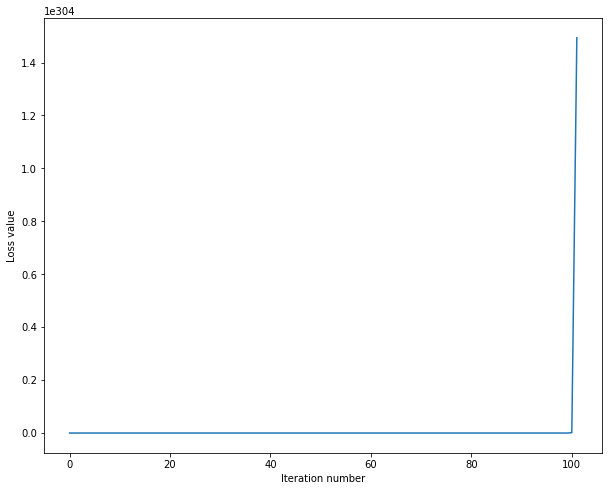

tr_acc: 0.100265306122 val_acc: 0.087
lr: 1e-05 reg: 0
iteration 0 / 15000: loss 19.489739
iteration 100 / 15000: loss 18.720495
iteration 200 / 15000: loss 16.612053
iteration 300 / 15000: loss 20.195477
iteration 400 / 15000: loss 14.452714
iteration 500 / 15000: loss 25.212482
iteration 600 / 15000: loss 21.002284
iteration 700 / 15000: loss 17.821700
iteration 800 / 15000: loss 18.134451
iteration 900 / 15000: loss 19.905833
iteration 1000 / 15000: loss 19.021316
iteration 1100 / 15000: loss 11.523430
iteration 1200 / 15000: loss 16.704924
iteration 1300 / 15000: loss 17.931986
iteration 1400 / 15000: loss 19.920253
iteration 1500 / 15000: loss 16.254979
iteration 1600 / 15000: loss 19.978786
iteration 1700 / 15000: loss 22.867464
iteration 1800 / 15000: loss 17.454316
iteration 1900 / 15000: loss 16.627098
iteration 2000 / 15000: loss 12.361639
iteration 2100 / 15000: loss 16.279710
iteration 2200 / 15000: loss 15.091275
iteration 2300 / 15000: loss 19.857161
iteration 2400 / 1500

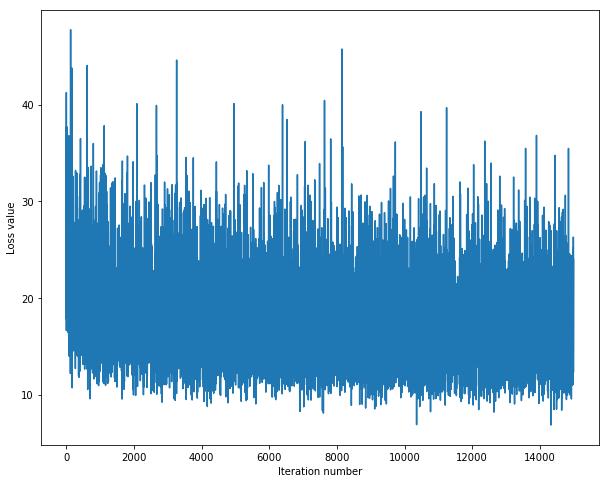

tr_acc: 0.33987755102 val_acc: 0.295
lr: 1e-05 reg: 50000.0
iteration 0 / 15000: loss 22.273153
iteration 100 / 15000: loss 37.194607
iteration 200 / 15000: loss 43.765657
iteration 300 / 15000: loss 40.301987
iteration 400 / 15000: loss 52.225237
iteration 500 / 15000: loss 42.342593
iteration 600 / 15000: loss 37.064177
iteration 700 / 15000: loss 37.024174
iteration 800 / 15000: loss 41.429773
iteration 900 / 15000: loss 28.600691
iteration 1000 / 15000: loss 29.205982
iteration 1100 / 15000: loss 59.318974
iteration 1200 / 15000: loss 50.632276
iteration 1300 / 15000: loss 41.426294
iteration 1400 / 15000: loss 38.667389
iteration 1500 / 15000: loss 37.922865
iteration 1600 / 15000: loss 33.957619
iteration 1700 / 15000: loss 41.991947
iteration 1800 / 15000: loss 49.304146
iteration 1900 / 15000: loss 36.350824
iteration 2000 / 15000: loss 45.742800
iteration 2100 / 15000: loss 39.636631
iteration 2200 / 15000: loss 45.767051
iteration 2300 / 15000: loss 44.685081
iteration 2400 /

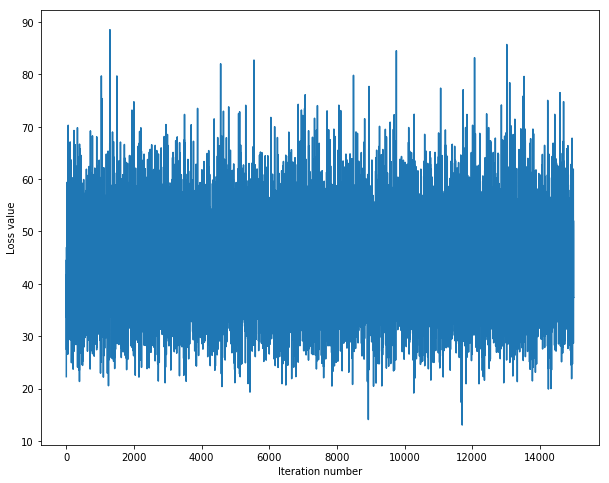

tr_acc: 0.193183673469 val_acc: 0.176
lr: 1e-05 reg: 100000.0
iteration 0 / 15000: loss 19.538291
iteration 100 / 15000: loss 68.725224
iteration 200 / 15000: loss 64.424400
iteration 300 / 15000: loss 75.647784
iteration 400 / 15000: loss 66.756115
iteration 500 / 15000: loss 73.127479
iteration 600 / 15000: loss 60.788738
iteration 700 / 15000: loss 77.153428
iteration 800 / 15000: loss 79.359643
iteration 900 / 15000: loss 87.579988
iteration 1000 / 15000: loss 56.438377
iteration 1100 / 15000: loss 66.505865
iteration 1200 / 15000: loss 89.795534
iteration 1300 / 15000: loss 69.547610
iteration 1400 / 15000: loss 62.498619
iteration 1500 / 15000: loss 74.545387
iteration 1600 / 15000: loss 90.408229
iteration 1700 / 15000: loss 70.550978
iteration 1800 / 15000: loss 81.062036
iteration 1900 / 15000: loss 83.309590
iteration 2000 / 15000: loss 72.782286
iteration 2100 / 15000: loss 68.392447
iteration 2200 / 15000: loss 90.119616
iteration 2300 / 15000: loss 75.248244
iteration 2400

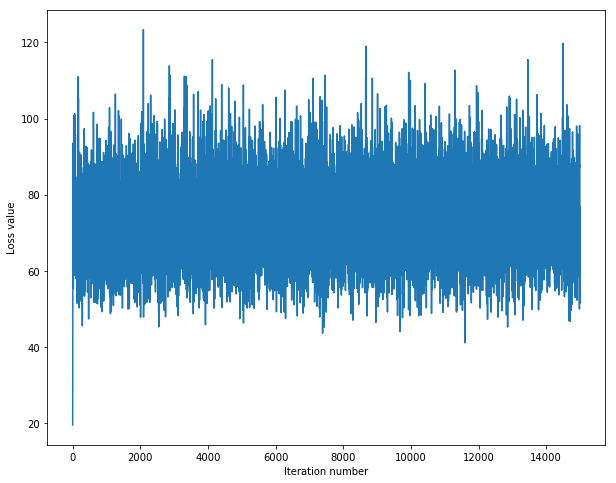

tr_acc: 0.171795918367 val_acc: 0.171
lr: 1e-05 reg: 10000000000.0
iteration 0 / 15000: loss 20.440858
iteration 100 / 15000: loss nan
iteration 200 / 15000: loss nan
iteration 300 / 15000: loss nan
iteration 400 / 15000: loss nan
iteration 500 / 15000: loss nan
iteration 600 / 15000: loss nan
iteration 700 / 15000: loss nan
iteration 800 / 15000: loss nan
iteration 900 / 15000: loss nan
iteration 1000 / 15000: loss nan
iteration 1100 / 15000: loss nan
iteration 1200 / 15000: loss nan
iteration 1300 / 15000: loss nan
iteration 1400 / 15000: loss nan
iteration 1500 / 15000: loss nan
iteration 1600 / 15000: loss nan
iteration 1700 / 15000: loss nan
iteration 1800 / 15000: loss nan
iteration 1900 / 15000: loss nan
iteration 2000 / 15000: loss nan
iteration 2100 / 15000: loss nan
iteration 2200 / 15000: loss nan
iteration 2300 / 15000: loss nan
iteration 2400 / 15000: loss nan
iteration 2500 / 15000: loss nan
iteration 2600 / 15000: loss nan
iteration 2700 / 15000: loss nan
iteration 2800 

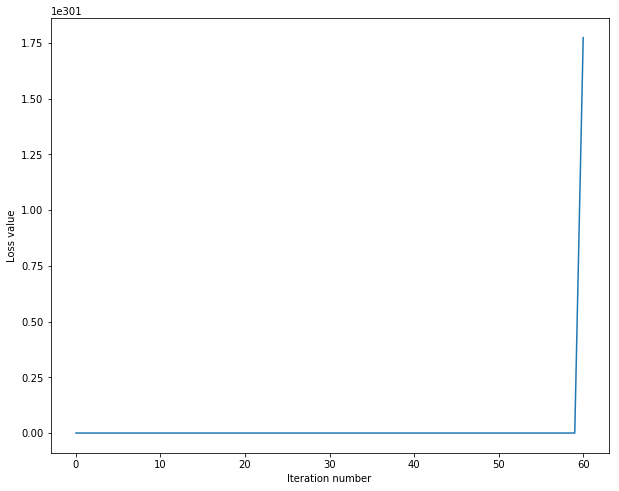

tr_acc: 0.100265306122 val_acc: 0.087
lr 1.000000e-10 reg 0.000000e+00 train accuracy: 0.158000 val accuracy: 0.170000
lr 1.000000e-10 reg 5.000000e+04 train accuracy: 0.112898 val accuracy: 0.112000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.143653 val accuracy: 0.146000
lr 1.000000e-10 reg 1.000000e+10 train accuracy: 0.226490 val accuracy: 0.230000
lr 1.000000e-08 reg 0.000000e+00 train accuracy: 0.306082 val accuracy: 0.321000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.375959 val accuracy: 0.389000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.362143 val accuracy: 0.374000
lr 1.000000e-08 reg 1.000000e+10 train accuracy: 0.100265 val accuracy: 0.087000
lr 1.000000e-07 reg 0.000000e+00 train accuracy: 0.384469 val accuracy: 0.357000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.368816 val accuracy: 0.376000
lr 1.000000e-07 reg 1.000000e+05 train accuracy: 0.354551 val accuracy: 0.350000
lr 1.000000e-07 reg 1.000000e+10 train accuracy: 0.100265 val accuracy:

In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-10, 1e-8, 1e-7, 1e-5]
regularization_strengths = [0, 5e4, 1e5, 1e10]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM
for lr in learning_rates:
    for reg in regularization_strengths:
        print "lr:", lr, "reg:", reg
        svm = LinearSVM()
        # first time set num_iters=200
        loss_hist = svm.train(X_train, y_train, lr, reg, num_iters=1500, verbose=True) 
        y_train_pred = svm.predict(X_train)
        train_acc = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
        print 'tr_acc:', train_acc, 'val_acc:', val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

(1e-08, 100000.0)
(1e-10, 0)
(1e-07, 100000.0)
(1e-05, 0)
(1e-07, 50000.0)
(1e-08, 0)
(1e-10, 10000000000.0)
(1e-05, 100000.0)
(1e-05, 50000.0)
(1e-10, 50000.0)
(1e-05, 10000000000.0)
(1e-07, 0)
(1e-07, 10000000000.0)
(1e-10, 100000.0)
(1e-08, 50000.0)
(1e-08, 10000000000.0)


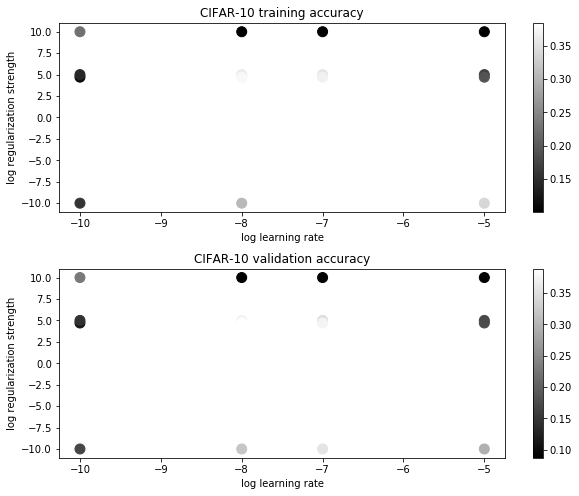

In [26]:
# Visualize the cross-validation results
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]+1e-10) for x in results]
for x in results:
    print x

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

plt.subplots_adjust(hspace = 0.3)

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [27]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.369000


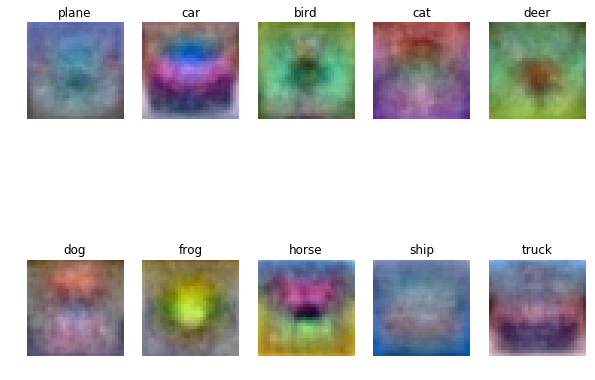

In [28]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*